# Run grpah asynchronously


In [1]:
from typing import Annotated

from typing_extensions import TypedDict

from langgraph.graph.message import add_messages

# Add messages essentially does this with more
# robust handling
# def add_messages(left: list, right: list):
#     return left + right


class State(TypedDict):
    messages: Annotated[list, add_messages]

In [2]:
# setup tools
from langchain_core.tools import tool


@tool
def search(query: str):
    """Call to surf the web."""
    # This is a placeholder, but don't tell the LLM that...
    return ["The answer to your question lies within."]


tools = [search]

In [3]:
from langgraph.prebuilt import ToolNode

tool_node = ToolNode(tools)

In [4]:
# setup model
from langchain_anthropic import ChatAnthropic

model = ChatAnthropic(model="claude-3-haiku-20240307")

In [5]:
model = model.bind_tools(tools)

In [6]:
from typing import Literal


# Define the function that determines whether to continue or not
def should_continue(state: State) -> Literal["end", "continue"]:
    messages = state["messages"]
    last_message = messages[-1]
    # If there is no tool call, then we finish
    if not last_message.tool_calls:
        return "end"
    # Otherwise if there is, we continue
    else:
        return "continue"


# Define the function that calls the model
async def call_model(state: State):
    messages = state["messages"]
    response = await model.ainvoke(messages)
    # We return a list, because this will get added to the existing list
    return {"messages": [response]}

In [7]:
from langgraph.graph import END, StateGraph, START

# Define a new graph
workflow = StateGraph(State)

# Define the two nodes we will cycle between
workflow.add_node("agent", call_model)
workflow.add_node("action", tool_node)

# Set the entrypoint as `agent`
# This means that this node is the first one called
workflow.add_edge(START, "agent")

# We now add a conditional edge
workflow.add_conditional_edges(
    # First, we define the start node. We use `agent`.
    # This means these are the edges taken after the `agent` node is called.
    "agent",
    # Next, we pass in the function that will determine which node is called next.
    should_continue,
    # Finally we pass in a mapping.
    # The keys are strings, and the values are other nodes.
    # END is a special node marking that the graph should finish.
    # What will happen is we will call `should_continue`, and then the output of that
    # will be matched against the keys in this mapping.
    # Based on which one it matches, that node will then be called.
    {
        # If `tools`, then we call the tool node.
        "continue": "action",
        # Otherwise we finish.
        "end": END,
    },
)

# We now add a normal edge from `tools` to `agent`.
# This means that after `tools` is called, `agent` node is called next.
workflow.add_edge("action", "agent")

# Finally, we compile it!
# This compiles it into a LangChain Runnable,
# meaning you can use it as you would any other runnable
app = workflow.compile()

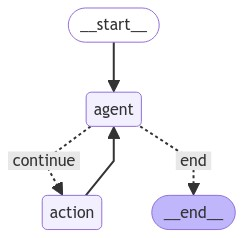

In [11]:
from IPython.display import Image, display

display(Image(app.get_graph().draw_mermaid_png()))

In [9]:
from langchain_core.messages import HumanMessage

inputs = {"messages": [HumanMessage(content="what is the weather in sf")]}
await app.ainvoke(inputs)

BadRequestError: Error code: 400 - {'type': 'error', 'error': {'type': 'invalid_request_error', 'message': 'messages.2.content.0.tool_result.content.0: Input should be a valid dictionary or object to extract fields from'}}

In [11]:
# streaming node output
inputs = {"messages": [HumanMessage(content="what is the weather in sf")]}
async for output in app.astream(inputs, stream_mode="updates"):
    # stream_mode="updates" yields dictionaries with output keyed by node name
    for key, value in output.items():
        print(f"Output from node '{key}':")
        print("---")
        print(value["messages"][-1].pretty_print())
    print("\n---\n")

Output from node 'agent':
---
================================== Ai Message ==================================

[{'id': 'toolu_018Ae8YgnXxDTEmQujd5XDa9', 'input': {'query': 'weather in SF'}, 'name': 'search', 'type': 'tool_use'}]
Tool Calls:
  search (toolu_018Ae8YgnXxDTEmQujd5XDa9)
 Call ID: toolu_018Ae8YgnXxDTEmQujd5XDa9
  Args:
    query: weather in SF
None

---

Output from node 'action':
---
================================= Tool Message =================================
Name: search

['The answer to your question lies within.']
None

---



BadRequestError: Error code: 400 - {'type': 'error', 'error': {'type': 'invalid_request_error', 'message': 'messages.2.content.0.tool_result.content.0: Input should be a valid dictionary or object to extract fields from'}}